In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct
import torchvision.models as models


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]


In [2]:
data_path="/root/data/ILSVRC2012_val/"

_, valid_datasets = get_datasets("imagenet1k", data_path)
_, valid_datasets2 = get_datasets("imagenet1k", data_path, transform=T.Compose([T.Resize(256),T.CenterCrop(256),]) )

device="cuda:0"


In [3]:
model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")


In [4]:
# n02443484: 40 black-footed_ferret
# n01614925: 398 bald_eagle

ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_idx = os.listdir(ferrot_dir)[2]
ferrot_img = Image.open(os.path.join(ferrot_dir, ferrot_idx))

eagle_dir = os.path.join(data_path, 'val', 'n01614925')
eagle_idx = os.listdir(eagle_dir)[1]
eagle_img = Image.open(os.path.join(eagle_dir, eagle_idx))


transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

ferrot_tensor = transform(ferrot_img)
eagle_tensor = transform(eagle_img)


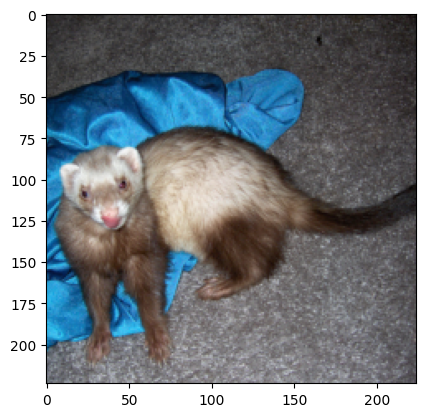

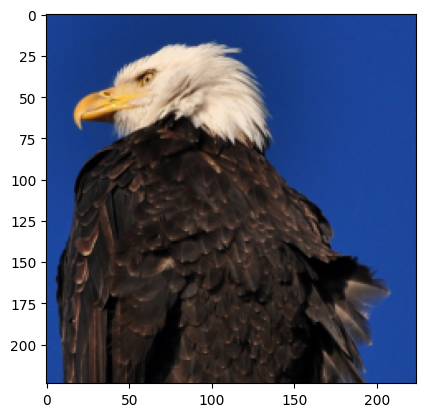

In [5]:
plt.figure()
plt.imshow(convert_to_img(ferrot_tensor))

plt.figure()
plt.imshow(convert_to_img(eagle_tensor))

In [ ]:
def ig(model, x, y, baseline, device='cuda:0', M=25, **kwrags):
    x = x.to(device)
    baseline = baseline.to(device)
    model.zero_grad()
    
    X = make_interpolation(x, M, baseline)
    X = Variable(X, requires_grad=True).to(device)
    X.retain_grad()
    
    output = model(X,)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(X.size(0), output.size()[-1]).zero_().to(device).type(X.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)

    gradient = X.grad  #Approximate the integral using the trapezoidal rule
    gradient = (gradient[:-1] + gradient[1:]) / 2.0
    output = (x - baseline) * gradient.mean(axis=0)
    output = output.mean(dim=0) # RGB mean
    output = output.abs()
    return output

In [7]:
def make_interpolation(x, M, baseline):
    lst = [] 
    for i in range(M+1):
        alpha = float(i/M)  
        interpolated =x * (alpha) + baseline * (1-alpha)
        lst.append(interpolated.clone())
    return torch.stack(lst)

In [19]:
# from torch.autograd import Variable

x = ferrot_tensor
baseline = torch.zeros_like(x)

x = x.to(device)
baseline = baseline.to(device)
model = model.to(device)
model.zero_grad()

X = make_interpolation(x, 10, baseline) # 10+1, 3, 224, 224
X = Variable(X, requires_grad=True).to(device)
X.retain_grad()

output = model(X,) # 11, 1000
score = torch.softmax(output, dim=-1) # 11, 1000 
class_score = torch.FloatTensor(X.size(0), output.size()[-1]).zero_().to(device).type(X.dtype)

labs = torch.argmax(score, dim = -1)
for i in labs:
    i = i.item()
    class_score[:,i] = score[:,i]
output.backward(gradient=class_score)

gradient = X.grad  #Approximate the integral using the trapezoidal rule
gradient = (gradient[:-1] + gradient[1:]) / 2.0
output = (x - baseline) * gradient.mean(axis=0)
output = output.mean(dim=0) # RGB mean
output = output.abs()


In [22]:
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))
attr, kwargs  = process_heatmap(output.cpu(), my_cmap)



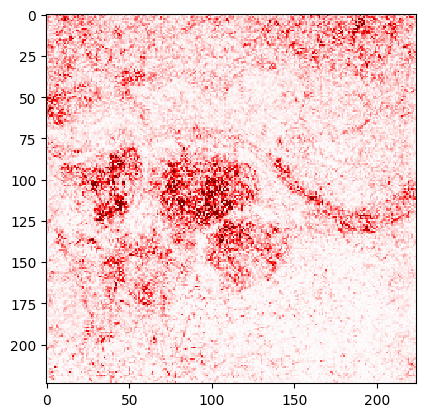

In [24]:
plt.imshow(attr, **kwargs)